In [14]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


notebook_name = 'k_means_clustering.ipynb'

current_dir = os.path.dirname(os.path.abspath(notebook_name))
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))


sys.path.insert(1, parent_dir)
from src.data_processer import TelecomDataProcessor


In [3]:
# Replace 'your_conn_params' with your actual connection parameters
conn_params = {
    'host': 'localhost',
    'port': 5432,
    'user': 'ekru',
    'password': 'ekram12345',
    'database': 'tellco',
}

telecom_data_processor = TelecomDataProcessor(conn_params)

In [4]:
df = telecom_data_processor.load_dataset()

/home/ekram/Desktop/week-1/user_analytics_in_the_telecommunication_industry/src/data_processer.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


In [6]:
cleaned_df = telecom_data_processor.clean_dataset(df)

In [7]:
telecom_data_processor.overview_analysis(cleaned_df)

          BEARER_ID       START_MS         END_MS     DUR._(MS)          IMSI  \
count  1.500010e+05  150001.000000  150001.000000  1.500010e+05  1.500010e+05   
mean   1.013887e+19     499.661213     499.273526  1.046086e+05  2.082016e+14   
std    2.883600e+18     288.201515     287.687241  8.103735e+04  2.144722e+10   
min    6.917538e+18       1.000000       1.000000  7.142000e+03  2.040471e+14   
25%    7.349883e+18     251.000000     252.000000  5.744200e+04  2.082014e+14   
50%    7.349883e+18     499.661213     500.000000  8.639900e+04  2.082015e+14   
75%    1.304243e+19     749.000000     750.000000  1.324300e+05  2.082018e+14   
max    1.318654e+19     999.000000     999.000000  1.859336e+06  2.140743e+14   

       MSISDN/NUMBER          IMEI  AVG_RTT_DL_(MS)  AVG_RTT_UL_(MS)  \
count   1.500010e+05  1.500010e+05    150001.000000    150001.000000   
mean    4.188282e+10  4.847455e+13       109.803795        18.280156   
std     2.438731e+12  2.237359e+13       559.341973   

In [15]:
# Aggregate sessions frequency per customer
sessions_frequency = cleaned_df.groupby('MSISDN/NUMBER')['BEARER_ID'].count().reset_index()
sessions_frequency.columns = ['MSISDN/NUMBER', 'SESSIONS FREQUENCY']

# Aggregate session duration per customer
session_duration = cleaned_df.groupby('MSISDN/NUMBER')['DUR._(MS)'].sum().reset_index()
session_duration.columns = ['MSISDN/NUMBER', 'TOTAL SESSION DURATION (MS)']

# Aggregate total traffic per customer (download + upload)
total_traffic = cleaned_df.groupby('MSISDN/NUMBER')['TOTAL_UL_(BYTES)', 'TOTAL_DL_(BYTES)'].sum().reset_index()
total_traffic['TOTAL TRAFFIC (BYTES)'] = total_traffic['TOTAL_UL_(BYTES)'] + total_traffic['TOTAL_DL_(BYTES)']
total_traffic = total_traffic[['MSISDN/NUMBER', 'TOTAL TRAFFIC (BYTES)']]

# Combine the metrics into a single DataFrame
engagement_metrics = pd.merge(sessions_frequency, session_duration, on='MSISDN/NUMBER')
engagement_metrics = pd.merge(engagement_metrics, total_traffic, on='MSISDN/NUMBER')

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics.drop('MSISDN/NUMBER', axis=1))

# Perform k-means clustering (k = 3)
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_clusters = kmeans.fit_predict(normalized_metrics)

engagement_metrics['CLUSTER'] = engagement_clusters

/tmp/ipykernel_3670/2540030454.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_traffic = cleaned_df.groupby('MSISDN/NUMBER')['TOTAL_UL_(BYTES)', 'TOTAL_DL_(BYTES)'].sum().reset_index()
/home/ekram/anaconda3/envs/week0/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/ekram/anaconda3/envs/week0/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ekram/anaconda3/envs/week0/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ekram/anaconda3/envs/week0/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ekram/anaconda3/envs/week0/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

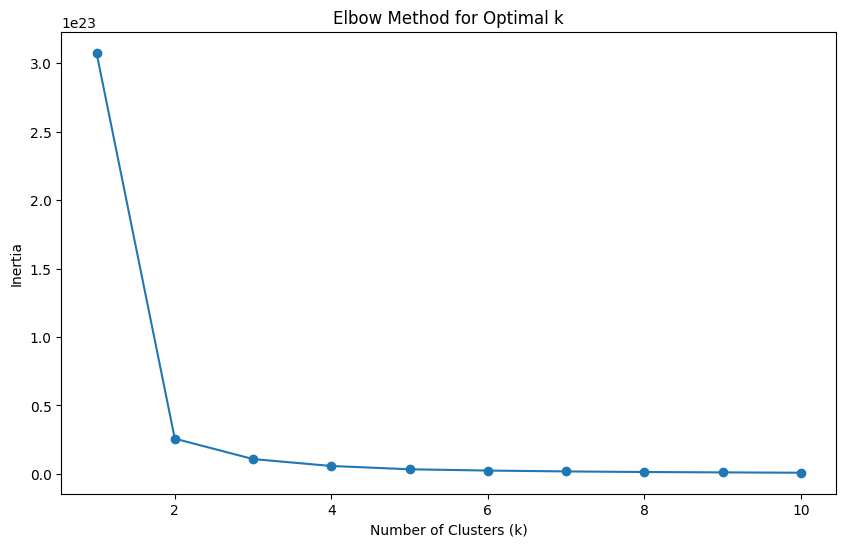

In [18]:
features_for_clustering = engagement_metrics[['SESSIONS FREQUENCY', 'TOTAL SESSION DURATION (MS)', 'TOTAL TRAFFIC (BYTES)']]

inertia = []

k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()